# CAB420, Neural Attention, Example 2: Transformers
Dr Simon Denman (s.denman@qut.edu.au)

# Overview

Transformers are a specific class of feed-foward network that achieve state of the art performance for sequence processing tasks, and dominante Natural Language Processing (NLP). Unlike recurrent models which store an internal memory to keep track of data over the sequence, transformers do not use memory or recurrent steps, and process the entire sequence at once. One of the main motivations for this to increase the parallelisation of the networks, allowing them to run faster in large (and expensive) GPU configurations. Attention is used liberally to help the model understand connections and relationships in the data.

For most tasks, multiple transformer units are stacked, allowing information to be extracted by successive passes through attention blocks. For sequence to sequence tasks, transformers are used to encode and then decode the representation, much like we've seen in auto-encoder or other image-to-image networks.

This example will keep things simple, and will:
* Build a simple transformer block
* Use this to complete out twitter sentiment classification task
Critically, we won't look the decoder stage which is used in applications such as language translation.

For those who are interested in further reading regarding transformers, the following are good starting places:
* [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
* [Tensor 2 Tensor Notebook (contains cool visualisation)](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)
* [Attention is all you need (the paper that introduced this architecture)](https://arxiv.org/abs/1706.03762)

To clarify, thankfully Michael Bay has no involvement what so ever in this example (although a few gratuitous explosions would be fun).

## Too Long; Didn't Read:
* Transformers offer an alternate way to process sequences, where the entire sequences is processed concurrently rather than sequentially as per an LSTM
* Inputs and outputs are sequences. Like an LSTM, inputs are embeddings, but unlike an LSTM the embedding captures information on the token **and it's position** in the sequence
* Transformer blocks can be stacked, like an LSTM
* Transformers are not, in the majority of cases, super efficient computionally. They offer much greater parallelisation than an LSTM, but you need to have large GPU resources, and be processing long sequences, to really benefit from this.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas
import numpy
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import model_to_dot, plot_model

## The Data
Still twitter data. Same setup as last time - though we're taking a few more samples as we're training a NN.

This is all taken from our previous examples, and we're doing the same thing here again.

In [2]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv')

tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])
Y[Y > 0] = 1

num_samples = 60000
train_samples = 50000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]

max_words = 50000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(test_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_X = pad_sequences(test_sequences, maxlen=max_length, padding='post')

## The Transformer

Prior to putting the network together, we'll create a couple of layers to help.

### Transformer Layer

This is a simple implementation of a transformer cell, take from [here](https://keras.io/examples/nlp/text_classification_with_transformer/).

The main bits of the block are:
* The multi-head attention layer, `self.att`
* The feed-forward network, `self.ffn`

The structure of the block is that we pass the data through the multi-head attention, and then pass the output through the feed forward network. This produces an output sequence the same length as the input sequence (though the embedding size may be different).

We'll wrap this up in a layer, simply to make it easier to use. This involves sub-classing `layers.Layer` and defining two functions:
* `init`: which defines how to create the layer
* `call`: which defines what to do when data get's pushed through the layer

In [3]:
# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

### Token and Position Embedding

Like our previous text-based deep learning methods, we use embeddings to represent words. However for the transformer our embedings don't represent just words - they also encode position.

Essentially what we have is two embedding layers, one which generates an embedding for the word, and one which generates an embedding for the position in the sequence. The idea being that the network should also understand the position of a word within a sequence. We then simply add these two embeddings together to obtain our input to the network.

In [4]:
# our embedding generator
class TokenAndPositionEmbedding(layers.Layer):
    # create the embedding generator
    # params are:
    # - maxlen: maximum length of a sequence
    # - vocab_size: number of words in the vocabulary
    # - embed_dim: size of the embeddings to create
    # Note that both embedding layers will create the same size embeddings so they can be added
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        # create the word token embedding layer
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # create the position embedding layer
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    # call function, do a forward pass through the layer
    # params are:
    # - x: data to get embedding for
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # get positions of the words in the sequence
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # get the position embeddings
        positions = self.pos_emb(positions)
        # get the token/word embeddings
        x = self.token_emb(x)
        # return the sum of the two embeddings
        return x + positions    

### The Network

Now we can create our network. This is not too complex, and all the heavy lifting is done by the two layers (really just the transformer layer) we created above.

We'll start with just a simple single transformer setup. Note that we have three parameters that we can tune up the top here:
* `embed_dim` is the size of the embedding dimension. Making this bigger will give the embeddings the ability to more richly describe the content, but also slow the model down.
* `num_heads` is the number of attention heads that we have in the network (transformers use multi-head attention). Increasing this will add attention heads, which will slow things down, but increase the networks ability to model relationships in the sequence (up to a point).
* `ff_dim` is the hidden layer size of the feed forward network inside the transformer. This is the size of the network that operates over the embeddings, so making this bigger allows for greater capacity, but at the usual cost of parameters and speed.

Feel free to play with these in your own time.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 token_and_position_embeddin  (None, 39, 128)          6404992   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 39, 128)          140832    
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 20)                2580  

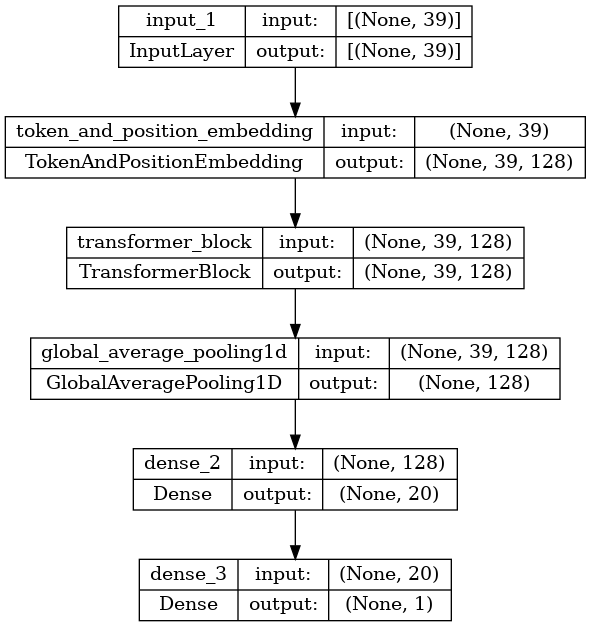

In [5]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# create the input
inputs = layers.Input(shape=(max_length,))
# get our embeddings, note that we're using the embedding layer from above
embedding_layer = TokenAndPositionEmbedding(max_length, max_words, embed_dim)
x = embedding_layer(inputs)
# create a transformer layer and pass the embeddings through that.
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
# now we just want co classify the output of our transformer into positive or negative sentiment
# we can use a couple of dense layers to step down from our transformer output to our final classification
# decision
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
plot_model(model, show_shapes=True)

We can now train the network as we normally would.

In [6]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_padded_X, train_Y, batch_size=128, epochs=2, validation_data=(test_padded_X, test_Y)
)

Epoch 1/2
391/391 [==============================] - 11s 22ms/step - loss: 0.5207 - accuracy: 0.7338 - val_loss: 0.4700 - val_accuracy: 0.7780
Epoch 2/2
391/391 [==============================] - 8s 21ms/step - loss: 0.3515 - accuracy: 0.8488 - val_loss: 0.4935 - val_accuracy: 0.7743


Test loss: 0.49348223209381104
Test accuracy: 0.7742999792098999


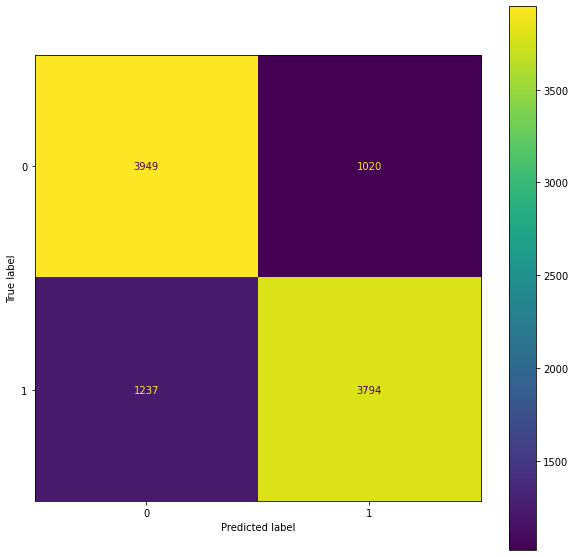

In [7]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=False)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test, verbose=False);
    pred = pred >= 0.5
    
    cm = confusion_matrix(y_test, pred)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)

eval_model(model, test_padded_X, test_Y)

Our network works pretty well - we're at 77% accuracy on the test set which is the best we've achieved on this data across our various examples.

We've also go there fairly quickly (in terms of epochs/training steps), and are starting to overfit after just two epochs. It's worth noting though that the training time per epoch is a lot slower than our LSTM methods. That said, transformers are a lot easier to parallelise than LSTMs which can make them quite efficient on GPUs.

### Stacked Transformers

Because we can, we'll now stack our transformer blocks. We'll just stack two, and we'll also change up some other parameters (again, because we can).

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 39)]              0         
                                                                 
 token_and_position_embeddin  (None, 39, 128)          6404992   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 39, 128)          280896    
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  (None, 39, 128)          280896    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 128)              0   

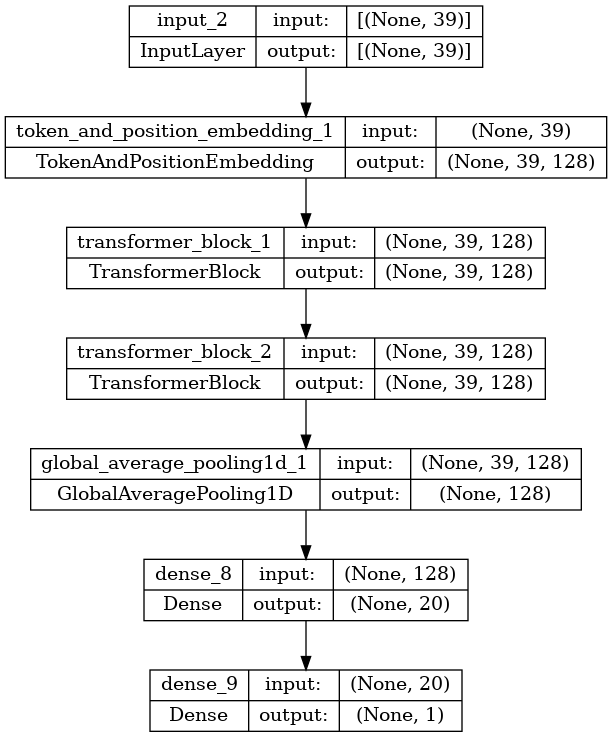

In [8]:
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads, note we've now made this 4
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

# input layer
inputs = layers.Input(shape=(max_length,))
# embedding, again this is the token and position layer
embedding_layer = TokenAndPositionEmbedding(max_length, max_words, embed_dim)
x = embedding_layer(inputs)
# first transformer
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
# second transformer, takes the output of the first transformer as input
transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_2(x)
# our classification block, as per the above
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
plot_model(model, show_shapes=True)

In [9]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_padded_X, train_Y, batch_size=128, epochs=2, validation_data=(test_padded_X, test_Y)
)

Epoch 1/2
391/391 [==============================] - 18s 40ms/step - loss: 0.6931 - accuracy: 0.5247 - val_loss: 0.5945 - val_accuracy: 0.6944
Epoch 2/2
391/391 [==============================] - 15s 39ms/step - loss: 0.4702 - accuracy: 0.7805 - val_loss: 0.4870 - val_accuracy: 0.7739


Test loss: 0.4870285093784332
Test accuracy: 0.7738999724388123


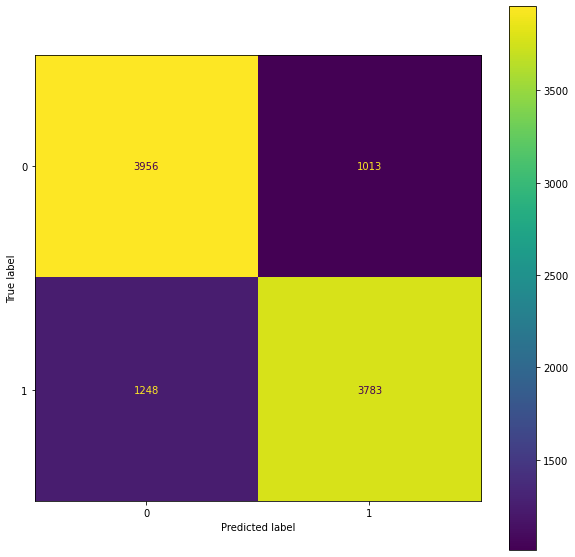

In [10]:
eval_model(model, test_padded_X, test_Y)

Performance wise, we're a touch below the first network, but could maybe push this a bit further before overfitting (though this does vary from one training run to the next - typically I'm seeing more severe overfitting for this more complex transformer than the first).

On the whole though, this is working pretty well, though with the stacked transformers is now running a lot slower than our first network (and other networks using this data).

## Final Thoughts

In this example we've had a brief look at transformers. These offer a very powerful way to process sequences, all using the magic of attention.

Their attention formulation is a bit different to what we've looked at in our earlier examples, but the formulation is quite common elsewhere and generally works well.

One thing you may have noted running this example is that it's not that quick. One of the motivations for transformers is that they don't need to process data sequentially, each element in a sequence can be processed simultaenously, while still capturing the relationship between elements. This does offer gains for long sequences and/or when very large compute resources are available, though we don't fit either of those criteria here (assuming you're not running this on some multi-GPU beast). 

While transformers started in text processing, there peformace for that task has seen them adopted elsewhere such as to [images](https://keras.io/examples/vision/image_classification_with_vision_transformer/). The application to images is perhpaps not obvious, as transformers by design operate over sequences. The solution to this is to break an image up into a series of small blocks, encode each of these, and then process it as a sequence. This allows a local feature representation to obtained for a small patch, and then the relationship between these patches to be modelled. By having the position embedding as well, the transformer can maintain knowledge of how patches are located relative to one another. 